# FELion Spectra
New Baseline correction and analysing method for FELion Spectra

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d as interpolate
from peakutils import indexes as peak_index
import rampy as rp

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi']=(100)

In [40]:
filename = "./DATA/16_11_18-3.felix"
powerfile = './DATA/16_11_18-3.pow'
shots = 16.0

v = {'lamb':10e5, 'smooth':0.05, 'p_value':0.01, 'iterations':10, 'mainfont':15, 'subfont':12}

# Custom definitions

In [31]:
def peakfind(x, y, \
             file,\
             threshold=0.5, gap=30, plot=True, marker=10, \
             ylabel='Intensity Normalised', \
             title = 'Spectrum'
            ):
    
    indexes = peak_index(y, thres=threshold, min_dist=gap)
    
    if plot:
        
        plt.figure()
        
        plt.plot(x, y)
        plt.plot(x[indexes], y[indexes],'+',ms=marker, label = 'peaks')
        
        for i in indexes:
            plt.annotate('%.2f'%x[i],xy=(x[i], y[i]), xytext=(x[i], y[i]))
        
        plt.legend()
        plt.xlabel('wavenumber $cm-1$')
        plt.ylabel(ylabel)
        plt.title(title+': %s'%file)
        
        plt.show()
        plt.close()
        
        print('Returning x, y and indexes')
        
    return x[indexes], y[indexes], indexes

# Making the plot vertical

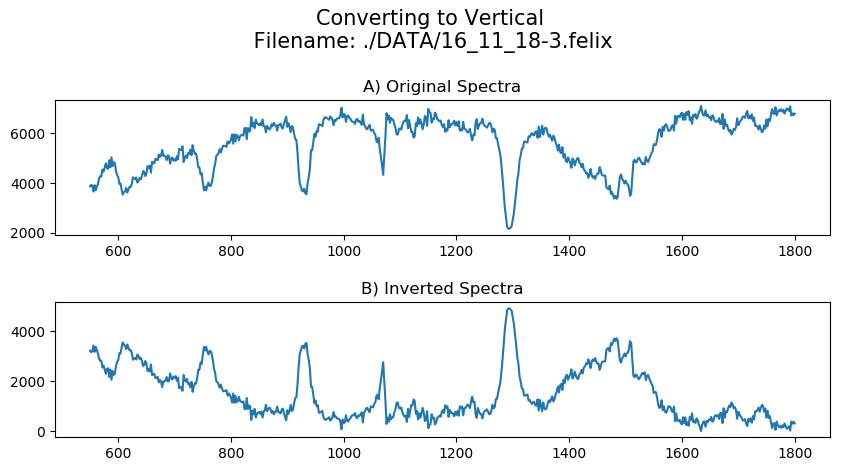

In [12]:
data = np.genfromtxt(filename)
x, y = data[:,0], data[:,2]
shape = data.shape[0]
y1 = y.max()-y

# the frequency regions devoid of signal, used by rp.baseline()
# bir is not used for als method; this is just to overcome the module program and no significant here
bir = np.array([[x.min(),x.mean(), x.max()]]) 

plt.figure()

plt.subplots_adjust(top=0.8,hspace = 0.5)

plt.suptitle("Converting to Vertical\n Filename: %s"%filename, fontsize = v['mainfont'])

plt.subplot(211)
plt.plot(x, y)
plt.title("A) Original Spectra", fontsize = v['subfont'])

plt.subplot(212)
plt.plot(x, y1)
plt.title("B) Inverted Spectra", fontsize = v['subfont'])

plt.show()
plt.close()

# Baseline Correction (using "automatic least square fitting following Eilers and Boelens 2005")

**P.H. Eilers, H.F. Boelens, Baseline correction with asymmetric least squares smoothing. Leiden University Medical Centre Report, 2005; 1, 5.**
[Google Scholar](http://scholar.google.com/scholar?hl=en&q=P.H.+Eilers%2C+H.F.+Boelens%2C+Baseline+correction+with+asymmetric+least+squares+smoothing.+Leiden+University+Medical+Centre+Report%2C+2005%3B+1%2C+5.
)


We can control the baseline using lambda, p, niter parameters

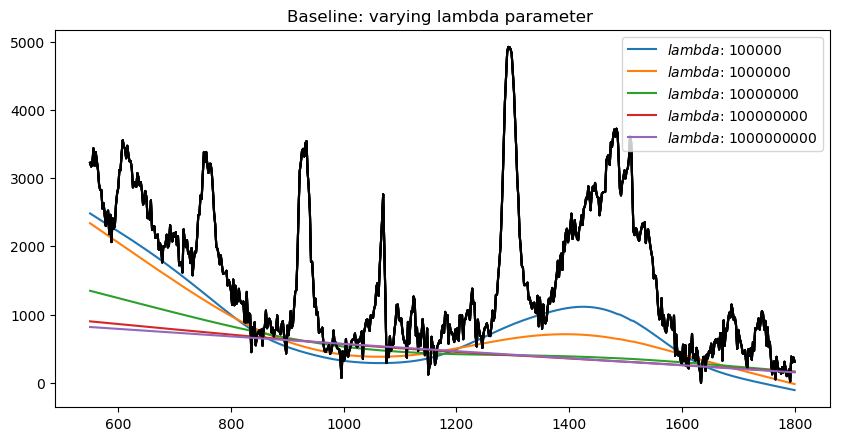

In [13]:
plt.figure()

for i in range(5, 10):
    lamb = 10**i
    y_param, b_param = rp.baseline(x, y1,bir,"als",lam = lamb)
    plt.plot(x, y1, '-k')
    plt.plot(x, b_param, label = '$lambda$: %s'%lamb)
    
plt.legend()
plt.title("Baseline: varying lambda parameter ")
plt.show()
plt.close()

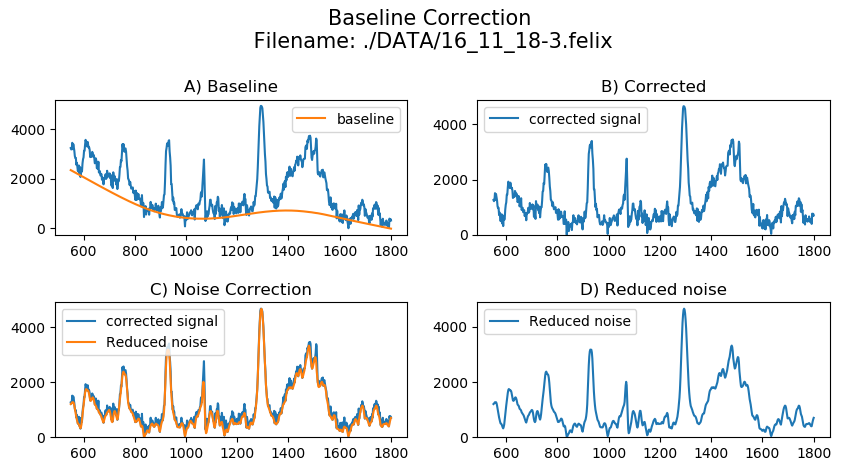

In [14]:
y_corrected, baseline = rp.baseline(x, y1,bir,"als",lam = v['lamb'], p = v['p_value'], niter = v['iterations'])

plt.figure()
plt.subplots_adjust(top=0.8, wspace = 0.2, hspace = 0.5)
plt.suptitle("Baseline Correction\n Filename: %s"%filename, fontsize = v['mainfont'])

plt.subplot(221)
plt.plot(x, y1)
plt.plot(x,baseline,label="baseline")
plt.title("A) Baseline", fontsize = v['subfont'])
plt.legend()

plt.subplot(222)
y_corrected = y_corrected-y_corrected.min()
plt.plot(x,y_corrected,label="corrected signal")
plt.title("B) Corrected", fontsize = v['subfont'])
plt.ylim(ymin=0)
plt.legend()

plt.subplot(223)
y_temp, y_smooth = rp.baseline(x, y_corrected,bir,"als",lam = v['smooth'])
plt.plot(x,y_corrected, label = 'corrected signal')
plt.plot(x, y_smooth, label = 'Reduced noise')
plt.title("C) Noise Correction", fontsize = v['subfont'])
plt.ylim(ymin=0)
plt.legend()

plt.subplot(224)
plt.plot(x, y_smooth, label = 'Reduced noise')
plt.title("D) Reduced noise", fontsize = v['subfont'])
plt.ylim(ymin=0)
plt.legend()

plt.show()
plt.close()

#Reshaping all the vaiables
x = x.reshape(shape,)
y1 = y1.reshape(shape,)
baseline = baseline.reshape(shape,)
y_corrected = y_corrected.reshape(shape,)
y_smooth = y_smooth.reshape(shape,)

#  Calculating the counts Drop Percentage

Calculating the ion drop count value using the baseline.

The drop count percentage can be calculate from the original spectra.

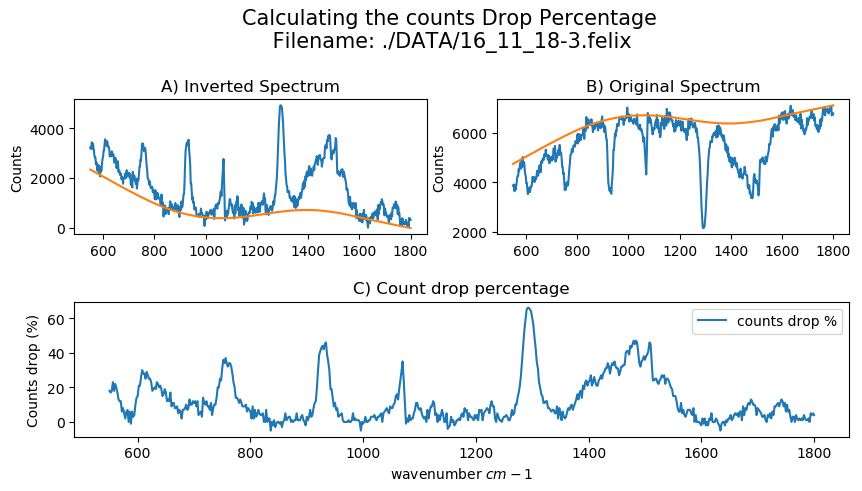

In [34]:
counts_drop = y1-baseline
original_baseline = y+counts_drop

counts_drop_percentage = ((original_baseline-y)/original_baseline)*100
counts_drop_percentage = counts_drop_percentage.astype(np.int)

plt.figure()

plt.suptitle("Calculating the counts Drop Percentage\n Filename: %s"%filename, fontsize = v['mainfont'])
plt.subplots_adjust(top=0.8, wspace = 0.2, hspace = 0.5)

plt.subplot(221)
plt.plot(x, y1)
plt.plot(x, baseline)
plt.title("A) Inverted Spectrum", fontsize = v['subfont'])
plt.ylabel('Counts')

plt.subplot(222)
plt.plot(x, y, label = 'original spectra')
plt.plot(x, original_baseline)
plt.title("B) Original Spectrum", fontsize = v['subfont'])
plt.ylabel('Counts')

plt.subplot(2,2,(3,4))
plt.plot(x, counts_drop_percentage, label = 'counts drop %')
plt.title("C) Count drop percentage", fontsize = v['subfont'])
plt.ylabel('Counts drop (%)')
plt.legend()

plt.xlabel('wavenumber $cm-1$')

plt.show()
plt.close()

# Finding Peaks

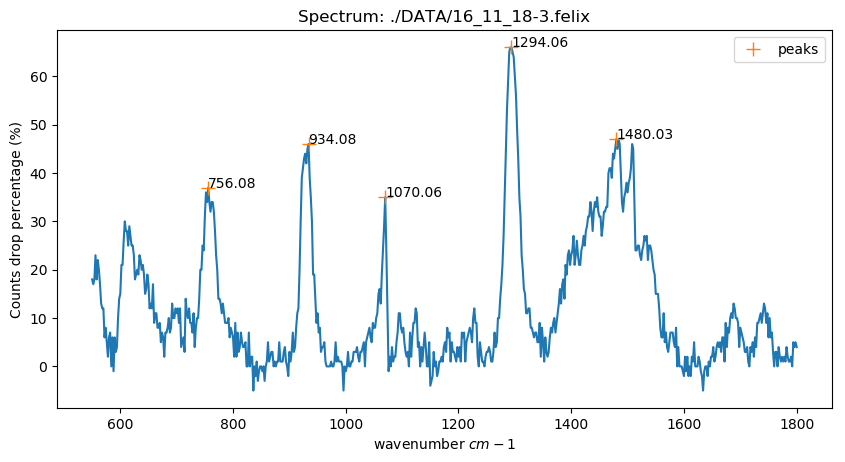

Returning x, y and indexes


(array([1480.027765, 1294.06284 , 1070.057179,  934.077569,  756.079465]),
 array([47, 66, 35, 46, 37]),
 array([158, 251, 363, 431, 520]))

In [33]:
peakfind(x, counts_drop_percentage, ylabel="Counts drop percentage (%)", threshold=0.5, file = filename)

# Power Calibration

Assuming the drop counts should be the same for all the runs and it is dependent on Power.
We normalise the signal as 

Normalised_Intensity = drop count (%) / Power (mJ)

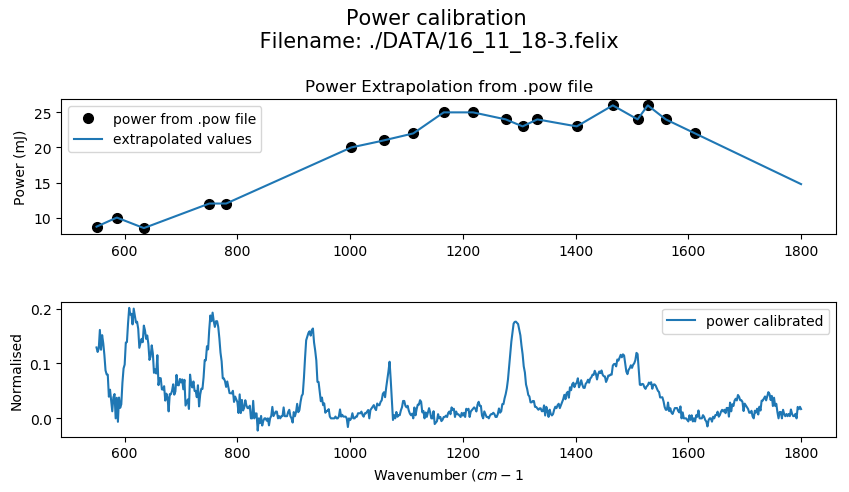

In [37]:
power_file = np.genfromtxt(powerfile)
power_file_extrapolate = interpolate(power_file[:,0], power_file[:,1], kind = 'linear', fill_value = 'extrapolate')
power_extrapolated = power_file_extrapolate(x)

plt.figure()

plt.suptitle("Power calibration\n Filename: %s"%filename, fontsize = v['mainfont'])
plt.subplots_adjust(top = 0.8, wspace = 0.2, hspace = 0.5)

plt.subplot(211)
plt.plot(power_file[:,0], power_file[:,1], 'ok',ms=7, label='power from .pow file')
plt.plot(x, power_extrapolated, '-', label='extrapolated values')
plt.legend()
plt.title('Power Extrapolation from .pow file')
plt.ylabel('Power (mJ)')


plt.subplot(212)
y_normalised = counts_drop_percentage/(power_extrapolated*shots)
plt.plot(x, y_normalised, label = 'power calibrated')
plt.xlabel('Wavenumber ($cm-1$')
plt.ylabel('Normalised')
plt.legend()

plt.show()
plt.close()